# cafe sales time series analysis
This notebook loads data and prepares the data for cafe sales time series analysis .

In [9]:
import pandas as pd
import numpy as np
print('Dataset is loaded for analysis')

Dataset is loaded for analysis


In [10]:
# load cafe sales dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/third/first semister/machine lear/mlproject/sales prediction model/dirty_cafe_sales.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [11]:
print(df.isnull().sum())

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64


In [15]:
#Numeric Columns: Convert Quantity, Price Per Unit, and Total Spent to numeric types:
df[['Quantity', 'Price Per Unit', 'Total Spent']] = df[['Quantity', 'Price Per Unit', 'Total Spent']].apply(pd.to_numeric, errors='coerce')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce', format='%Y-%m-%d')

#Replace "UNKNOWN" and "ERROR" with NaN for consistency:
df.replace(['UNKNOWN', 'ERROR', 'UnKNOWN'], pd.NA, inplace=True)

In [16]:
# List of numeric columns
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

# Fill missing values with the median of each column
# Fill missing values with the median of each numeric column
median_dict = {col: df[col].median() for col in numeric_cols}
df.fillna(median_dict, inplace=True)

In [21]:
# List of categorical columns
categorical_cols = ['Item', 'Payment Method', 'Location']

# Fill missing values with the mode (most frequent value) of each column
for col in categorical_cols:
    mode_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode_value)

# Categorical Data Standardization
categorical_cols = ['Item', 'Payment Method', 'Location']

for col in categorical_cols:
    df[col] = df[col].str.upper()

#Check for duplicate Transaction ID:
df.drop_duplicates(subset=['Transaction ID'], inplace=True)
df =df.dropna(subset=['Transaction Date'])

In [22]:
# See how many missing values exist in each column
print(df.isnull().sum())

df.info()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 9540 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    9540 non-null   object        
 1   Item              9540 non-null   object        
 2   Quantity          9540 non-null   float64       
 3   Price Per Unit    9540 non-null   float64       
 4   Total Spent       9540 non-null   float64       
 5   Payment Method    9540 non-null   object        
 6   Location          9540 non-null   object        
 7   Transaction Date  9540 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 670.8+ KB


In [23]:
# data = pd.get_dummies(data, columns=['Payment Method', 'Location', 'Item'], drop_first=True)
df = pd.get_dummies(df, columns=['Payment Method', 'Location', 'Item'], drop_first=True)

#checking the VIF value
X = df.drop(columns=['Total Spent', 'Transaction ID'])
y = df['Total Spent']
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
X_const = sm.add_constant(X)  # adds a constant column of 1s for intercept
X_const_bool_fixed = X_const.copy()
# Add constant again if needed
X_const_bool_fixed = sm.add_constant(X_const_bool_fixed)

X_const_bool_fixed['Year'] = X_const_bool_fixed['Transaction Date'].dt.year
X_const_bool_fixed['Month'] = X_const_bool_fixed['Transaction Date'].dt.month
X_const_bool_fixed['day'] = X_const_bool_fixed['Transaction Date'].dt.day

X_const_bool_fixed = X_const_bool_fixed.drop(columns=['Transaction Date'])

bool_cols = X_const_bool_fixed.select_dtypes(include=['bool']).columns
X_const_bool_fixed[bool_cols] = X_const_bool_fixed[bool_cols].astype(int)

# Make sure constant is present (if not, add it)
if 'const' not in X_const_bool_fixed.columns:
    X_const_bool_fixed = add_constant(X_const_bool_fixed)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const_bool_fixed.columns
vif_data["VIF"] = [variance_inflation_factor(X_const_bool_fixed.values, i) for i in range(X_const_bool_fixed.shape[1])]

print(vif_data[vif_data["Feature"] != "const"])

                          Feature       VIF
1                        Quantity  1.000413
2                  Price Per Unit  6.666889
3      Payment Method_CREDIT CARD  1.550446
4   Payment Method_DIGITAL WALLET  1.552261
5               Location_TAKEAWAY  1.001807
6                     Item_COFFEE  2.204921
7                     Item_COOKIE  3.227533
8                      Item_JUICE  2.275578
9                      Item_SALAD  3.345856
10                  Item_SANDWICH  2.165857
11                  Item_SMOOTHIE  2.129797
12                       Item_TEA  2.562201
13                           Year  0.000000
14                          Month  1.001382
15                            day  1.000957


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9540 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction ID                 9540 non-null   object        
 1   Quantity                       9540 non-null   float64       
 2   Price Per Unit                 9540 non-null   float64       
 3   Total Spent                    9540 non-null   float64       
 4   Transaction Date               9540 non-null   datetime64[ns]
 5   Payment Method_CREDIT CARD     9540 non-null   bool          
 6   Payment Method_DIGITAL WALLET  9540 non-null   bool          
 7   Location_TAKEAWAY              9540 non-null   bool          
 8   Item_COFFEE                    9540 non-null   bool          
 9   Item_COOKIE                    9540 non-null   bool          
 10  Item_JUICE                     9540 non-null   bool          
 11  Item_SALAD            

In [25]:
df = df.sort_values('Transaction Date')
df.set_index('Transaction Date', inplace=True)

daily_sales = df['Total Spent'].resample('D').sum()

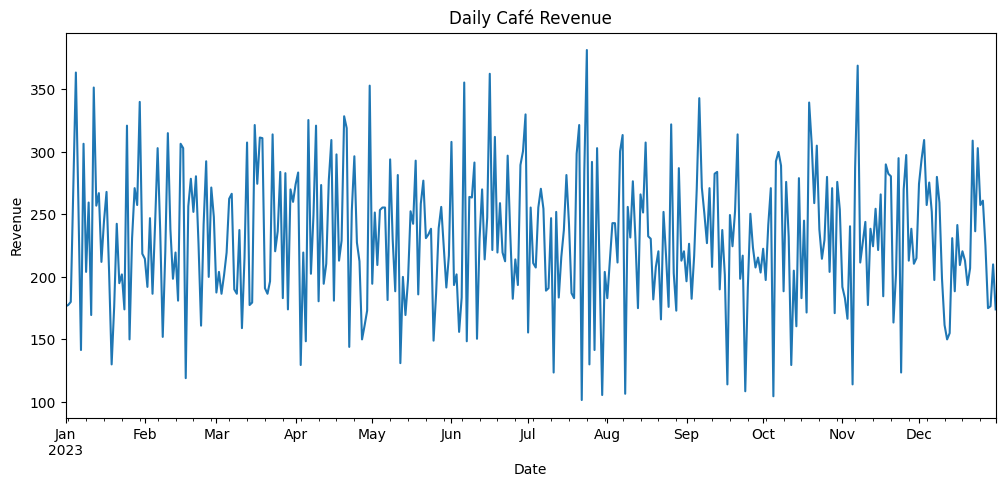

In [26]:
import matplotlib.pyplot as plt

daily_sales.plot(figsize=(12,5))
plt.title("Daily Café Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()